In [214]:
# tuning params
    # splitting strategy --> in splits_create.ipynb
    # embedding function / model --> in vector_db_create.ipynb in create_collection function
    # text generation moel --> in this script
    # prompt template --> in this script
    # (temperature --> in this script)

from replicate import Client
from langchain.prompts import PromptTemplate
import os
import pandas as pd
from tqdm import tqdm

In [222]:
SPLITS_PATH = "../resources/splits/"
def do_q_call(passage: str):
    template = """
        Erstelle genau eine (1) in der deutschen Sprache formulierte Frage zu folgendem Kontext.
        Achte hierbei auf fachliche Korrektheit und Vollständigkeit:
        
        ---
        {context}
        ---
        
        Gebe ausschließlich die Frage an! Ohne weiteren Text!
        """
    prompt_template = PromptTemplate(
            input_variables=["context"],
            template=template,
    )
    prompt = prompt_template.format(context=passage)
    replicateSession = Client(api_token="r8_c7xatuN0lmkBFqlgCXvas56nRkRWBeS1aXtWL")
    input = {
        "system_prompt": "Du bist ein deutschsprachiger, hilfreicher Assisten für das deutsche Bankenrecht. Beantworte die Anfrage des Nutzers in deutsch.",
        "prompt": prompt,
        # "min_new_tokens": 0,
        "max_new_tokens": 1024,
        # "temperature": 0.7,
    }
    iterator = replicateSession.run(
        "meta/meta-llama-3-70b-instruct", # "meta/llama-2-70b-chat", # "meta/meta-llama-3-8b",  # "mistralai/mixtral-8x7b-instruct-v0.1",
        input=input,
    )
    q = ""
    for text in iterator:
        q += text
    return q

def do_a_call(question: str, passage: str):
    template = """
        Beantworte folgende Frage in der deutschen Sprache.

        ---
        {question}
        ---

        Nutze für die Beantwortung der Frage folgenden Kontext:

        ---
        {context}
        ---
        
        Gebe ausschließlich die Antwort als Fließtext, ohne weitere Bemerkungen an!
        """
    prompt_template = PromptTemplate(
            input_variables=["question", "context"],
            template=template,
    )
    prompt = prompt_template.format(question=question, context=passage)
    replicateSession = Client(api_token="r8_c7xatuN0lmkBFqlgCXvas56nRkRWBeS1aXtWL")
    input = {
        "system_prompt": "Du bist ein deutschsprachiger Assisten für das deutsche Bankenrecht. Beantworte die Anfrage des Nutzers in deutsch.",
        "prompt": prompt,
        # "min_new_tokens": 0,
        "max_new_tokens": 1024,
        # "temperature": 0.7, # default
    }
    iterator = replicateSession.run(
        "meta/meta-llama-3-70b-instruct", # "meta/llama-2-70b-chat", # "meta/meta-llama-3-8b",  # "mistralai/mixtral-8x7b-instruct-v0.1",
        input=input,
    )
    a = ""
    for text in iterator:
        a += text
    return a

In [223]:
def create_qa_pairs(split_folder: str):
    file_names = os.listdir(SPLITS_PATH + split_folder)
    with open("../resources/TestFragen/log.txt", "w", encoding='utf-8') as f:
        for file in file_names:
            print("creating q_and_a for file " + file)
            qa_df = pd.DataFrame(columns=["question", "answer"])
            file_path = SPLITS_PATH + split_folder + file
            df = pd.read_json(file_path)

            documents_ = df['splits'].to_list()
            if len(documents_) == 0:
                print("No splits in file " + file_path + ". Skipping file.")
                break

            for split in tqdm(documents_):
                question = do_q_call(split)
                answer = do_a_call(question, split)
                
                f.write("-------------------\n")
                f.write(question + "\n")
                f. write("---\n")
                f.write(answer + "\n")
                f.write("-------------------\n\n")

                data = [{"file": file, "question": question, "answer": answer}] # list because of better pd.df 
                df = pd.DataFrame(data)
                qa_df = pd.concat([qa_df, df], ignore_index=True)
                
            qa_df.to_json("../resources/TestFragen/" + file)
            print("Done creating qa pairs for file " + file + ". Written to json file.")


In [224]:
create_qa_pairs("pdf_pages/")

creating q_and_a for file CELEX_02013L0036-20220101_DE_TXT.json


  1%|          | 1/162 [00:39<1:47:16, 39.98s/it]


Done creating qa pairs for file CELEX_02013L0036-20220101_DE_TXT.json. Written to json file.
creating q_and_a for file CELEX_02013R0575-20230628_DE_TXT.json


  0%|          | 1/746 [00:44<9:16:45, 44.84s/it]


Done creating qa pairs for file CELEX_02013R0575-20230628_DE_TXT.json. Written to json file.
creating q_and_a for file KWG.json


  1%|          | 1/196 [00:54<2:57:55, 54.75s/it]

Done creating qa pairs for file KWG.json. Written to json file.


## SCRIPT FINISH JUST TESTING CODE HERE

In [ ]:
def qa_pairs_to_json(q_and_a: str):
    q_and_a = q_and_a.split("\n")
    q_and_a = [x for x in q_and_a if x != '']
    if len(q_and_a) == 2:    
        qa_dict = {}
        qa_dict["question"] = q_and_a[0].replace('Frage: ', '', 1)
        qa_dict["answer"] = q_and_a[1].replace('Antwort: ', '', 1)
    else:
        print("Error: Could not split q_and_a into q and a.")
        return None
    return qa_dict

In [ ]:
model_answer = """
Frage: Was ist das deutsche Bankenrecht?
Antwort: DAS HALT.
"""

model_answer2 = """
Frage: UND DAS NÖCHSTE?
Antwort: NOCHMAL
"""

qa_df = pd.DataFrame(columns=["question", "answer"])
qa_pairs_json = [qa_pairs_to_json(model_answer)]
df = pd.DataFrame(qa_pairs_json)
qa_df = pd.concat([qa_df, df], ignore_index=True)


qa_pairs_json = [qa_pairs_to_json(model_answer2)]
df = pd.DataFrame(qa_pairs_json)
qa_df = pd.concat([qa_df, df], ignore_index=True)

qa_df.head()

In [ ]:
def split_long_split(split: str):
    split_list = []
    num_chars_max = 5000
    while True:
        if len(split) > num_chars_max:
            split_list.append(split[:num_chars_max])
        else:
            split_list.append(split)
            break
        split = split[num_chars_max:]
    return split_list

In [130]:
df = None # pd.DataFrame(columns=["question", "answer"])

qa_df = pd.DataFrame(columns=["question", "answer"])

qa_df = pd.concat([qa_df, df], ignore_index=True)

In [ ]:
l1 = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
l2 = ["k", "l", "m", "n", "o", "p", "q", "r", "s", "t"]
l3 = ["u", "v", "w", "x", "y", "z"]
l1 += l2
l1 += l3
print(l1)

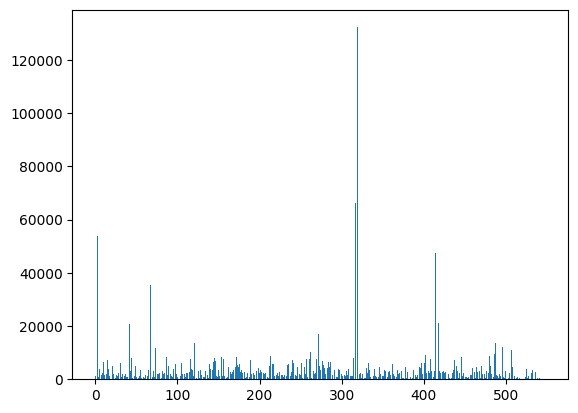

1349
<class 'list'>
1


In [99]:
# df = pd.read_json(SPLITS_PATH + "article_regex_splitter/CELEX_02013L0036-20220101_DE_TXT.json")
df = pd.read_json(SPLITS_PATH + "article_regex_splitter/CELEX_02013R0575-20230628_DE_TXT.json")
len(df['splits'])

# bar chart for length of each split, splits on x-axis, length on y-axis
import matplotlib.pyplot as plt
splits = df['splits']
split_lengths = [len(split) for split in splits]
plt.bar(np.arange(len(split_lengths)), split_lengths)
plt.show()

# get longest split
longest_split = df['splits'][0]
# longest_split = max(df['splits'], key=len)
print(len(longest_split))

# function to split a split into multiple splits if length > 5000 characters
def split_long_split(split: str):
    split_list = []
    while True:
        if len(split) > 5000:
            split_list.append(split[:5000])
        else:
            split_list.append(split)
            break
        split = split[5000:]
    return split_list

list_ = split_long_split(longest_split)
print(type(list_))
print(len(list_))

In [153]:
passage = """
Artikel 513  
Vorschriften der Makroaufsicht  
(1) Die Kommission überprüft nach Konsultation des ESRB und der  
EBA bis zum 30. Juni 2022 und danach alle fünf Jahre, ob die Vo r­
schriften dieser Verordnung und der Richtlinie 2013/36/EU zur M akro­
aufsicht ausreichen, um Systemrisiken in bestimmten Wirtschafts zwei­
gen, Regionen und Mitgliedstaaten einzudämmen; dabei bewertet s ie 
unter anderem,  
a) ob die geltenden Instrumente der Makroaufsicht dieser Verord nung 
und der Richtlinie 2013/36/EU wirksam, effizient und transparen t 
sind;  
b) ob die Abdeckung der verschiedenen in dieser Verordnung und der 
Richtlinie 2013/36/EU zur Bewältigung ähnlicher Risiken vorgese ­
henen Instrumente der Makroaufsicht und der eventuelle Grad der  
Überschneidung zwischen diesen Instrumenten angemessen sind; er ­
forderlichenfalls schlägt sie neue Vorschriften der Makroaufsic ht vor;  
c) welche Wechselwirkungen es zwischen international vereinbart en 
Standards für systemrelevante Institute und dieser Verordnung u nd 
der Richtlinie 2013/36/EU gibt; erforderlichenfalls schlägt sie  neue 
Vorschriften vor, in denen diese international vereinbarten Sta ndards 
berücksichtigt werden;  
d) ob andere Arten von Instrumenten wie schuldnerbezogene Instr u­
mente unter die in dieser Verordnung und der Richtlinie 2013/36 /EU 
vorgesehenen Instrumente der Makroaufsicht aufgenommen werden 
sollten, um die kapitalbezogenen Instrumente zu ergänzen und ei ne 
harmonisierte Anwendung der Instrumente im Binnenmarkt zu er­
möglichen, unter Berücksichtigung der Frage, ob harmonisierte D e­
finitionen dieser Instrumente und die Meldung entsprechender Da ten 
auf Unionsebene eine Voraussetzung für die Einführung solcher I n­
strumente sind;  
"""

response = do_qa_call(passage)

response

TypeError: string indices must be integers